<center> <b>
    <font size = 8, color = '#e0c989'>
Online Retail Sales Analysis

<b/><center/>

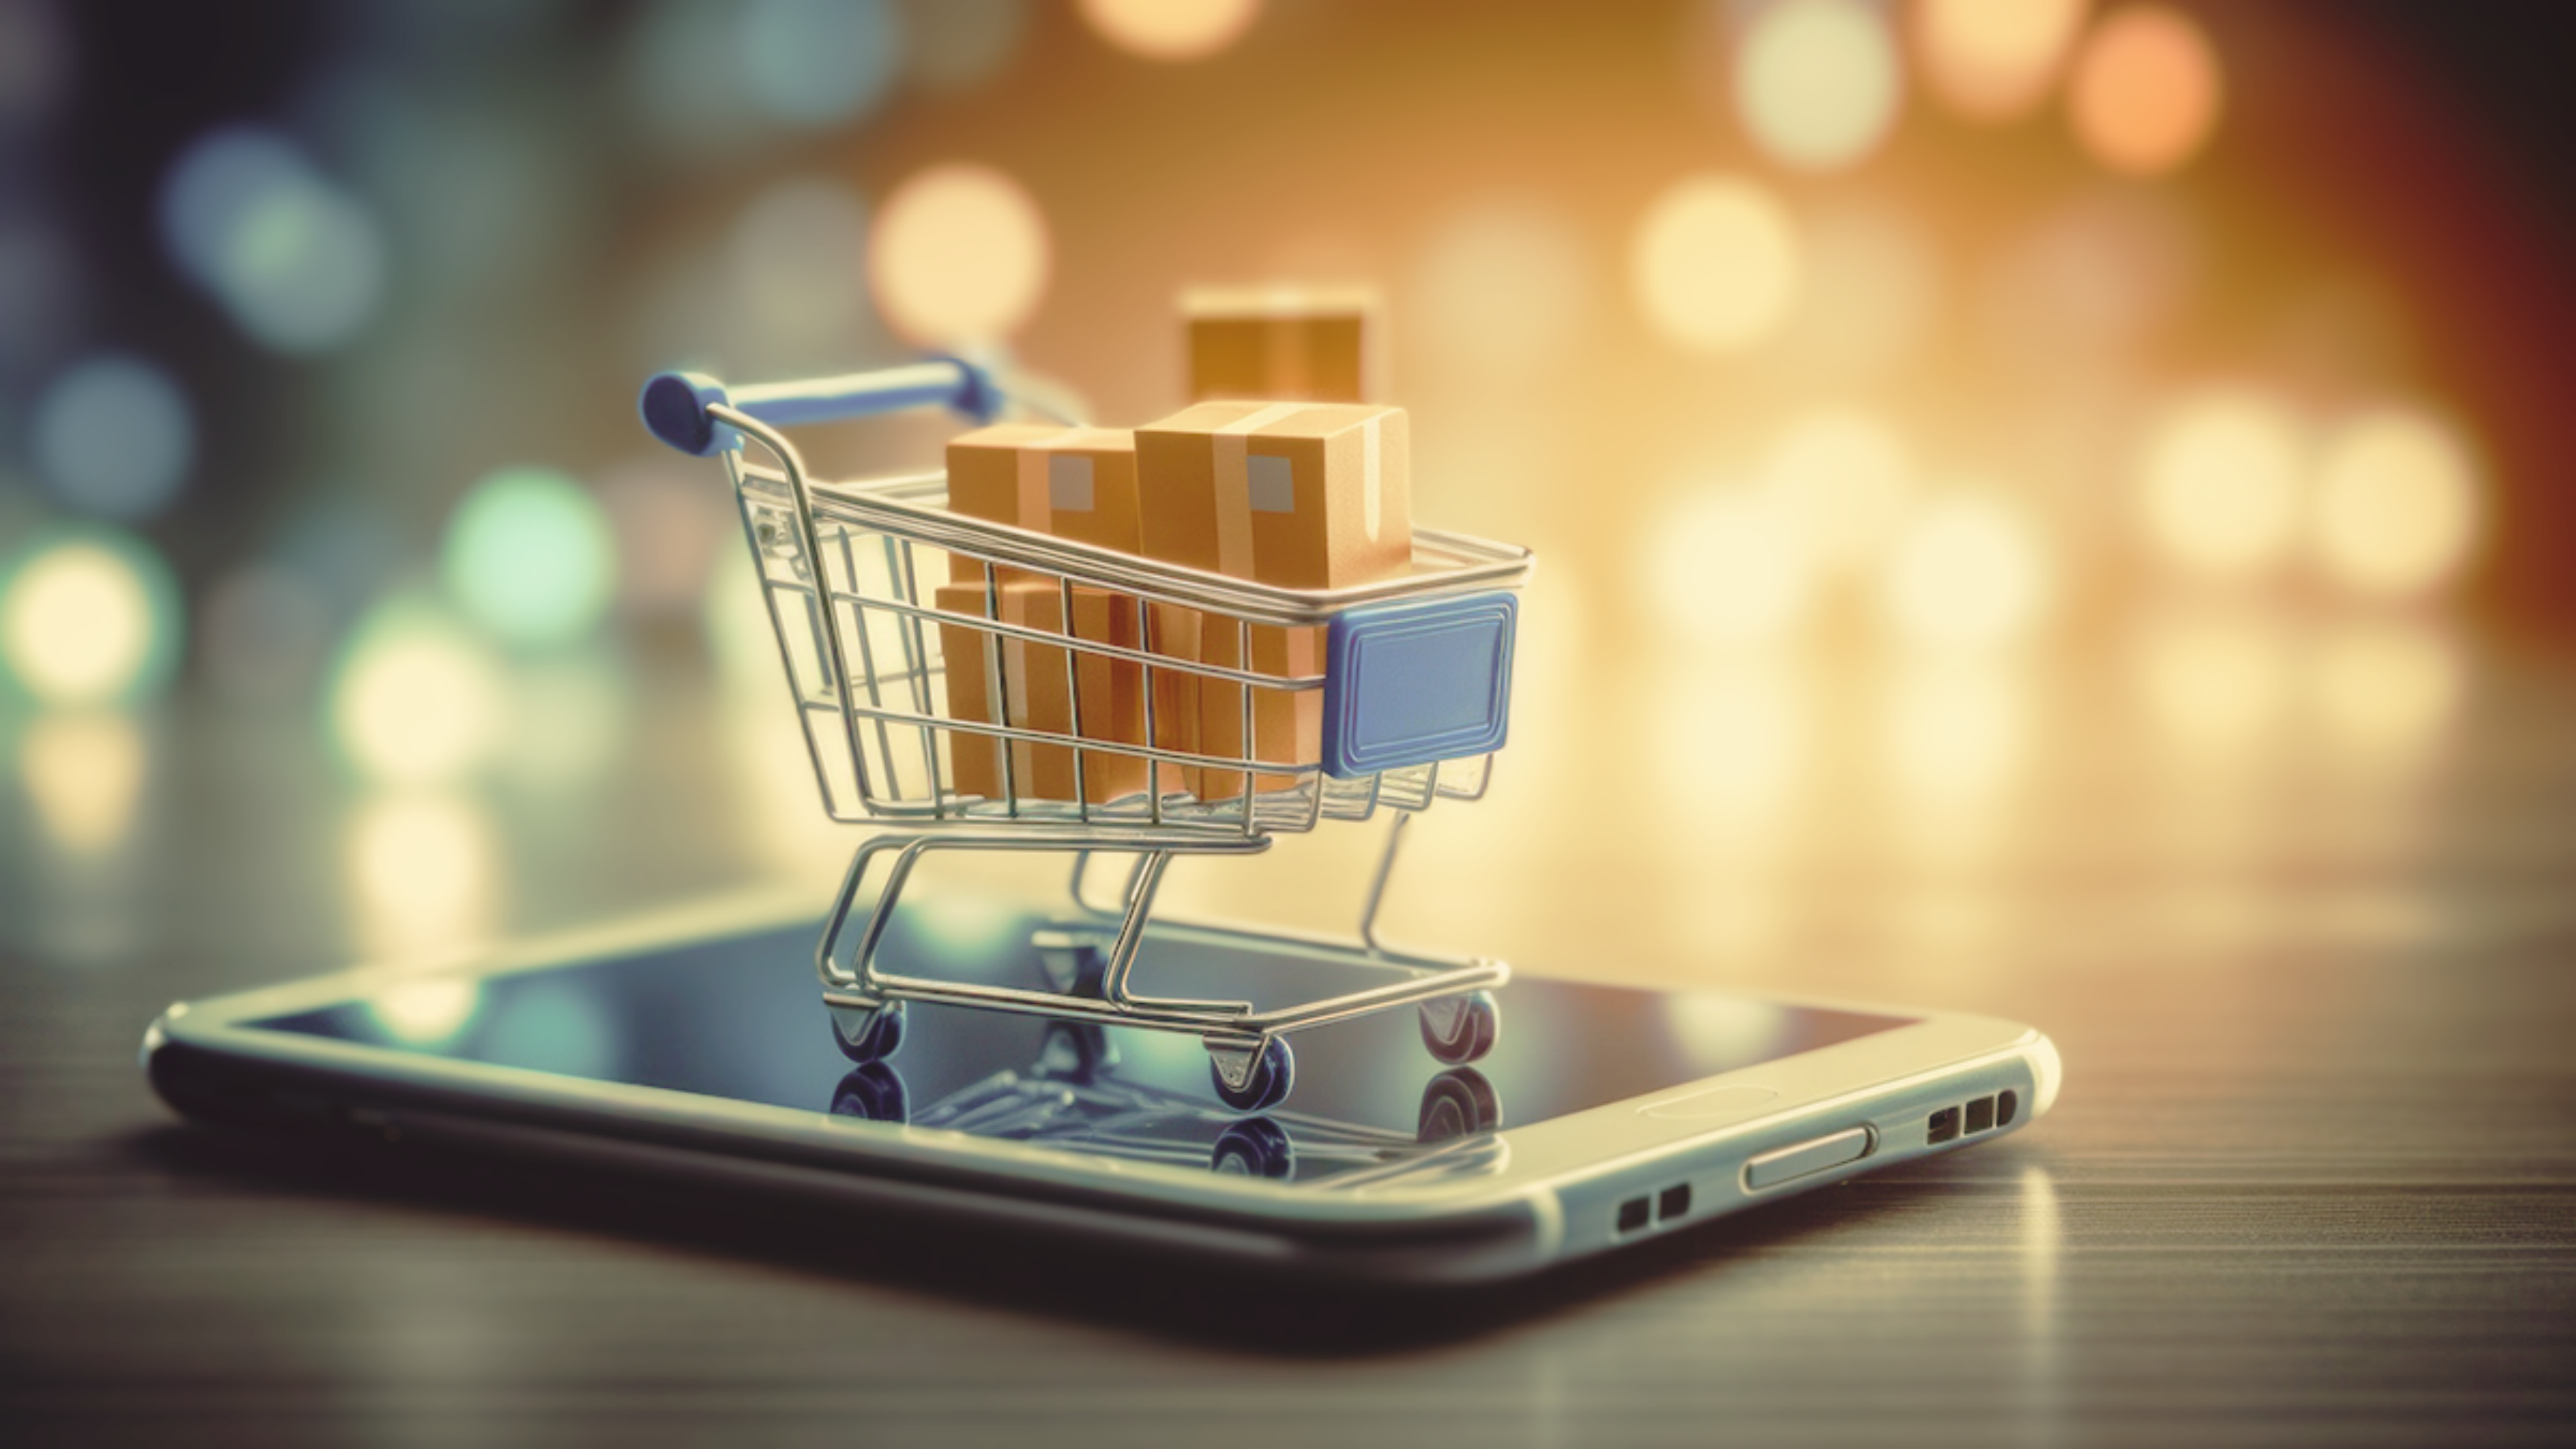

In [1]:
from IPython.display import display, Image

display(Image('OnlineRetailSalesAnalysisCover.png'))

## Summary

- Project Objective:
This project aims to analyse purchasing patterns of items from an online retail company based in the United Kingdom. By examining transaction data spanning from December 1, 2010, to December 9, 2011, we will uncover insights into customer purchasing behaviors.

- Data Overview:
The dataset contains detailed records of transactions over the specified time period. Additional dataset information will be explored in the Exploratory Data Analysis (EDA) and Data Provenance sections to understand its structure, quality, and origins.

## Dependencies

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# For frequent patterns identification
from mlxtend.frequent_patterns import association_rules, fpgrowth

# Ignoring warnings
from warnings import filterwarnings as fw
fw('ignore')

## Exploratory Data Analysis

In [3]:
# Reading the dataset as pandas dataframe

df = pd.read_csv('OnlineRetailDataset.csv', encoding = 'ISO-8859-1')
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

In [4]:
# Main information of the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# Dropping missing values (just for Description)

df.dropna(inplace = True, subset = 'Description')

In [6]:
# Displaying the main info of the dataset after handling missing values

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 540455 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    540455 non-null  object 
 1   StockCode    540455 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     540455 non-null  int64  
 4   InvoiceDate  540455 non-null  object 
 5   UnitPrice    540455 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      540455 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 37.1+ MB


In [7]:
# Dataframe containing the sales information

df_sales = df.copy()
df_sales.insert(6, 'Sales', df.UnitPrice*df.Quantity)
df_sales.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  Sales  CustomerID         Country  
0  12/1/2010 8:26       2.55  15.30     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39  20.34     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75  22.00     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39  20.34     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39  20.34     17850.0  United Kingdom

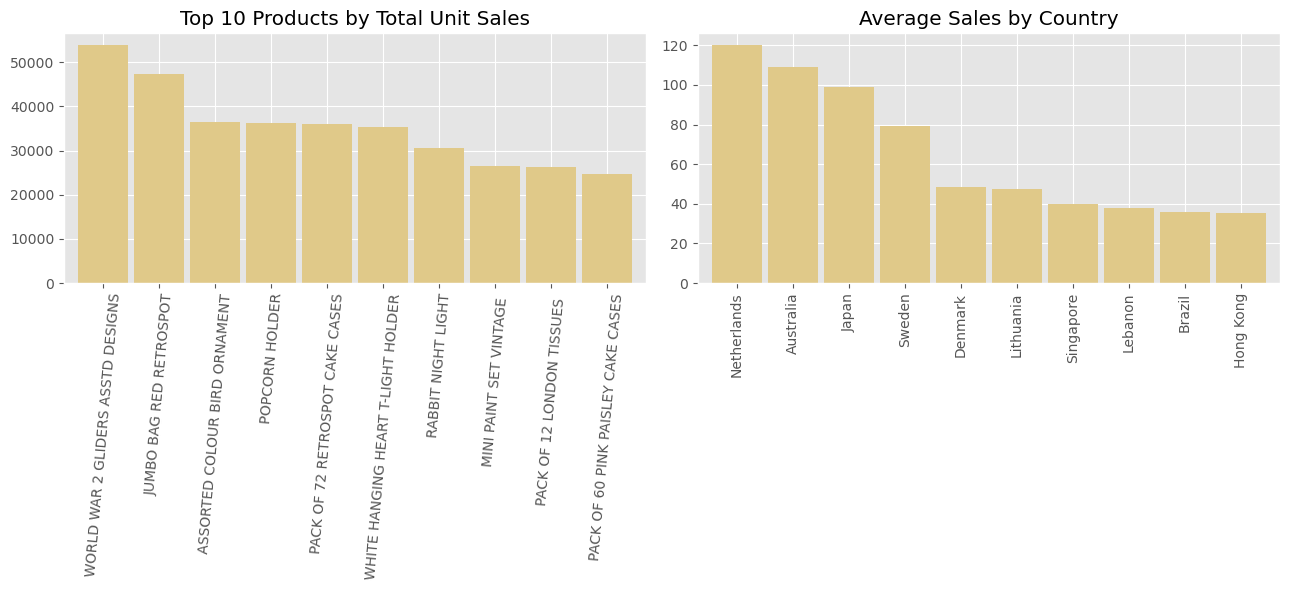

In [8]:
# Analysing the total unit and average sales by products and countries

fig, axes = plt.subplots(ncols = 2, figsize = (13, 6))

df_sales_top_products_total = df_sales.groupby('Description')['Quantity'].sum().sort_values(ascending = False).head(10)
df_sales_to_contries_mean = df_sales.groupby('Country')['Sales'].mean().sort_values(ascending = False).head(10)

# Plotting for products unit sales distribution
df_sales_top_products_total.plot.bar(color = '#e0c989', width = .9, ax = axes[0])
axes[0].set_title('Top 10 Products by Total Unit Sales')
axes[0].set_xticks(labels = list(df_sales_top_products_total.index), 
                   ticks = np.arange(10), rotation = 85)
axes[0].set_xlabel('')

# Plotting for country average sales distribution
df_sales_to_contries_mean.plot.bar(color = '#e0c989', width = .9, ax = axes[1])
axes[1].set_title('Average Sales by Country')
axes[1].set_xlabel('')

plt.tight_layout()
plt.show()

## Frequent Pattern analysis

In [9]:
# Since we just want to recommend for those who have already paid, it's better to drop all transactions done on credit 'C'. 
# Let's first check the total of transactions on credit

df.InvoiceNo.str.contains('C').sum()

9288

In [10]:
# Dropping transactions done on credit

df = df[~(df.InvoiceNo.str.contains('C'))]
df.InvoiceNo.str.contains('C').sum()

0

In [11]:
# Analysing countries by number of invoices

df.groupby('Country')['InvoiceNo'].count().sort_values(ascending = False).head()

Country
United Kingdom    486168
Germany             9042
France              8408
Egypt               7894
Spain               2485
Name: InvoiceNo, dtype: int64

In [12]:
# Let's analyse the sales pattern for UK, which contains the highest number of unique sales

df_asc_int = pd.crosstab(df.InvoiceNo, df.Description)

df_asc_int

Description   4 PURPLE FLOCK DINNER CANDLES   50'S CHRISTMAS GIFT BAG LARGE  \
InvoiceNo                                                                     
536365                                    0                               0   
536366                                    0                               0   
536367                                    0                               0   
536368                                    0                               0   
536369                                    0                               0   
...                                     ...                             ...   
581586                                    0                               0   
581587                                    0                               0   
A563185                                   0                               0   
A563186                                   0                               0   
A563187                                   0                               0   

Description   DOLLY GIRL BEAKER   I LOVE LONDON MINI BACKPACK  \
InvoiceNo                                                       
536365                        0                             0   
536366                        0                             0   
536367                        0                             0   
536368                        0                             0   
536369                        0                             0   
...                         ...                           ...   
581586                        0                             0   
581587                        0                             0   
A563185                       0                             0   
A563186                       0                             0   
A563187                       0                             0   

Description   I LOVE LONDON MINI RUCKSACK   NINE DRAWER OFFICE TIDY  \
InvoiceNo                                                             
536365                                  0                         0   
536366                                  0                         0   
536367                                  0                         0   
536368                                  0                         0   
536369                                  0                         0   
...                                   ...                       ...   
581586                                  0                         0   
581587                                  0                         0   
A563185                                 0                         0   
A563186                                 0                         0   
A563187                                 0                         0   

Description   OVAL WALL MIRROR DIAMANTE    RED SPOT GIFT BAG LARGE  \
InvoiceNo                                                            
536365                                 0                         0   
536366                                 0                         0   
536367                                 0                         0   
536368                                 0                         0   
536369                                 0                         0   
...                                  ...                       ...   
581586                                 0                         0   
581587                                 0                         0   
A563185                                0                         0   
A563186                                0                         0   
A563187                                0                         0   

Description   SET 2 TEA TOWELS I LOVE LONDON    SPACEBOY BABY GIFT SET  ...  \
InvoiceNo                                                               ...   
536365                                      0                        0  ...   
536366                                      0         

In [13]:
# Lets finally convert the previous dataframe values to boolean (as it is demanded by the algorithmn)

df_asc = df_asc_int.map(lambda cell: bool(cell))
df_asc

Description   4 PURPLE FLOCK DINNER CANDLES   50'S CHRISTMAS GIFT BAG LARGE  \
InvoiceNo                                                                     
536365                                False                           False   
536366                                False                           False   
536367                                False                           False   
536368                                False                           False   
536369                                False                           False   
...                                     ...                             ...   
581586                                False                           False   
581587                                False                           False   
A563185                               False                           False   
A563186                               False                           False   
A563187                               False                           False   

Description   DOLLY GIRL BEAKER   I LOVE LONDON MINI BACKPACK  \
InvoiceNo                                                       
536365                    False                         False   
536366                    False                         False   
536367                    False                         False   
536368                    False                         False   
536369                    False                         False   
...                         ...                           ...   
581586                    False                         False   
581587                    False                         False   
A563185                   False                         False   
A563186                   False                         False   
A563187                   False                         False   

Description   I LOVE LONDON MINI RUCKSACK   NINE DRAWER OFFICE TIDY  \
InvoiceNo                                                             
536365                              False                     False   
536366                              False                     False   
536367                              False                     False   
536368                              False                     False   
536369                              False                     False   
...                                   ...                       ...   
581586                              False                     False   
581587                              False                     False   
A563185                             False                     False   
A563186                             False                     False   
A563187                             False                     False   

Description   OVAL WALL MIRROR DIAMANTE    RED SPOT GIFT BAG LARGE  \
InvoiceNo                                                            
536365                             False                     False   
536366                             False                     False   
536367                             False                     False   
536368                             False                     False   
536369                             False                     False   
...                                  ...                       ...   
581586                             False                     False   
581587                             False                     False   
A563185                            False                     False   
A563186                            False                     False   
A563187                            False                     False   

Description   SET 2 TEA TOWELS I LOVE LONDON    SPACEBOY BABY GIFT SET  ...  \
InvoiceNo                                                               ...   
536365                                  False                    False  ...   
536366                                  False         

In [14]:
# Setting the support threshold (it means that we'll considered only items with a 3% of representation over the total of transactions, 
# that is sold 3 times in each 100 sales)

items_support_uk = fpgrowth(df_asc, min_support = 0.03, use_colnames = True)
items_support_uk 

support                                           itemsets
0    0.109656               (WHITE HANGING HEART T-LIGHT HOLDER)
1    0.070597                    (ASSORTED COLOUR BIRD ORNAMENT)
2    0.037700                         (HOME BUILDING BLOCK WORD)
3    0.030519                         (LOVE BUILDING BLOCK WORD)
4    0.054973                         (JAM MAKING SET WITH JARS)
..        ...                                                ...
121  0.035129  (JUMBO BAG RED RETROSPOT, JUMBO STORAGE BAG SUKI)
122  0.032994  (JUMBO BAG RED RETROSPOT, JUMBO SHOPPER VINTAG...
123  0.031101  (LUNCH BAG RED RETROSPOT, LUNCH BAG  BLACK SKU...
124  0.037263  (ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...
125  0.030713  (PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...

[126 rows x 2 columns]

In [15]:
# From all 4207 different items, we have now 126 with a minimum representation of 3%

items_association_uk =  association_rules(items_support_uk, metric = 'lift', min_threshold = 6)
items_association_uk.sort_values(['confidence', 'lift'], ascending = [False, False]) 

antecedents                         consequents  \
10    (PINK REGENCY TEACUP AND SAUCER)   (GREEN REGENCY TEACUP AND SAUCER)   
9    (GREEN REGENCY TEACUP AND SAUCER)  (ROSES REGENCY TEACUP AND SAUCER )   
8   (ROSES REGENCY TEACUP AND SAUCER )   (GREEN REGENCY TEACUP AND SAUCER)   
3            (JUMBO BAG PINK POLKADOT)           (JUMBO BAG RED RETROSPOT)   
0         (ALARM CLOCK BAKELIKE GREEN)         (ALARM CLOCK BAKELIKE RED )   
11   (GREEN REGENCY TEACUP AND SAUCER)    (PINK REGENCY TEACUP AND SAUCER)   
5             (JUMBO STORAGE BAG SUKI)           (JUMBO BAG RED RETROSPOT)   
1          (ALARM CLOCK BAKELIKE RED )        (ALARM CLOCK BAKELIKE GREEN)   
7            (LUNCH BAG  BLACK SKULL.)           (LUNCH BAG RED RETROSPOT)   
6            (LUNCH BAG RED RETROSPOT)           (LUNCH BAG  BLACK SKULL.)   
2            (JUMBO BAG RED RETROSPOT)           (JUMBO BAG PINK POLKADOT)   
4            (JUMBO BAG RED RETROSPOT)            (JUMBO STORAGE BAG SUKI)   

    antecedent support  consequent support   support  confidence       lift  \
10            0.037166            0.049248  0.030713    0.826371  16.779804   
9             0.049248            0.051722  0.037263    0.756650  14.629045   
8             0.051722            0.049248  0.037263    0.720450  14.629045   
3             0.059098            0.101504  0.040029    0.677340   6.673028   
0             0.047550            0.050995  0.031053    0.653061  12.806462   
11            0.049248            0.037166  0.030713    0.623645  16.779804   
5             0.057448            0.101504  0.035129    0.611486   6.024253   
1             0.050995            0.047550  0.031053    0.608944  12.806462   
7             0.061766            0.075885  0.031101    0.503535   6.635457   
6             0.075885            0.061766  0.031101    0.409847   6.635457   
2             0.101504            0.059098  0.040029    0.394359   6.673028   
4             0.101504            0.057448  0.035129    0.346080   6.024253   

    leverage  conviction  zhangs_metric  
10  0.028883    5.475760       0.976705  
9   0.034716    3.896768       0.979901  
8   0.034716    3.401012       0.982458  
3   0.034030    2.784651       0.903540  
0   0.028628    2.735368       0.967940  
11  0.028883    2.558314       0.989116  
5   0.029297    2.312650       0.884836  
1   0.028628    2.435585       0.971453  
7   0.026414    1.861389       0.905206  
6   0.026414    1.589813       0.919036  
2   0.034030    1.553566       0.946185  
4   0.029297    1.441388       0.928223

From the dataframe above, the top items confidence shows that that there are 16 times more chances of purchasing  GREEN REGENCY TEACUP AND SAUCER everytime PINK REGENCY TEACUP AND SAUCER is purchased too than independently.  A combo for this products in UK should be a good sales strategy.

## Data Provenance

<p>
    <strong> Source</strong>
    <br>
    UCI Machine Learning Repository.
    <a href = 'https://archive.ics.uci.edu/dataset/352/online+retail' target = '_blank' >
        Online Retail Dataset.</a>    
    <br><br> 
    <strong> Introductory Paper</strong><br>
    <a href = 'https://www.semanticscholar.org/paper/e43a5a90fa33d419df42e485099f8f08badf2149' target = '_blank'>
       Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining. 
    </a>
    Daqing Chen, Sai Laing Sain, Kun Guo. 2012. n Journal of Database Marketing and Customer Strategy Management, Vol. No. 3.
     <br><br>
    <strong>Licence</strong><br>
    <a href = 'https://creativecommons.org/licenses/by/4.0/legalcode' target = '_blank'>
     Creative Commons Attribution 4.0 International.</a>
    <br><br><br>
<em>Last accessed on October, 30 2024.</em>


<p/>

                 ________  ________   _______   ______
                 /_  __/ / / / ____/  / ____/ | / / __ \
                  / / / /_/ / __/    / __/ /  |/ / / / /
                 / / / __  / /___   / /___/ /|  / /_/ /
                /_/ /_/ /_/_____/  /_____/_/ |_/_____/  
